# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

<div class="alert alert-block alert-success" style='text-align: justify;font-family:Georgia;'>
In this corporate world, every company wants to hire the best resources available on the market. Therefore, Human Resource (HR) department plays an important role in hiring new resources for the company. As we know that there are many steps involved in finding and hiring the right candidates but the important and final one is giving an acceptable offer to candidates. After spending so much time on searching and interviewing candidates, it is very important that HR team gives a competitive salary in order to hire them. For HR team, determing salary range for candicates involves so many factors like industry, location, years of experience, roles and reposibilites. As it is a very complex process, they need a quick and relaiable system that they can use for determining a competitive salary for candidates. <br>  

The goal of this project is predicting a competitive salary for candidates based on the industry,role, years of experience and many attributes. This project is using python and its libraries for salary prediction.
</div>

In [4]:
#import your libraries
import os
import sys
import pathlib
import numpy as np
import pandas as pd
import string
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import pylab
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV,cross_val_score,KFold,train_test_split
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor

from feature_engine.discretisers import EqualWidthDiscretiser

#your info here
__author__ = "Vijayan Nallasami"
__email__ = "VNallasami@gmail.com"

In [5]:
# config variables and display settings
PATH = 'data/'
FILENAMES = {'train_feature':'train_features.csv','train_target':'train_salaries.csv','test':'test_features.csv'}
TARGET = 'salary'
ID = 'jobId'

pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)
np.set_printoptions(linewidth=100)

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [10]:
# load files into pandas dataframe
class LoadData:
    
    def __init__(self,PATH,FILENAMES,TARGET,ID):
        
        self.file_path = PATH
        self.file_dict = FILENAMES
        self.target_column = TARGET
        self.merge_Id = ID
        self.load_data()
        self.merge_df()
        self.find_feature_type()
              
    # read csv data and load it in dataframe
    def load_data(self):
        
        for name, file in self.file_dict.items():
            
            if name == 'train_feature':
                self.train_features = pd.read_csv(self.file_path+file)
            if name == 'train_target':
                self.train_target = pd.read_csv(self.file_path+file)
            if name == 'test':
                self.test_features = pd.read_csv(self.file_path+file)
    
    # merge features and target in a single dataframe
    def merge_df(self):
        
        self.train = pd.merge(self.train_features,self.train_target,on=self.merge_Id)
        self.train.drop(labels=self.merge_Id,axis=1,inplace=True)
        self.test = self.test_features.drop(labels=self.merge_Id,axis=1)
    
    # find numerical and categorical features
    def find_feature_type(self):
        
        self.numerical_features = self.train.select_dtypes(exclude='object').columns
        self.categorical_features = self.train.select_dtypes('object').columns    
        
    # split dataframe as features and target
    def split_X_y(self, df, target):
        
        X = df.drop(labels=target,axis=1)
        y = df[target]
        
        return X,y

### ---- 3 Clean the data ----

In [7]:
# clean up duplicate and invalid records
class CleanUp:
    
    def __init__(self, target_name, target_min_val):
        
        self.target_min_val = target_min_val
        self.target_column  = target_name        
        
    def fit(self,df):        
        return self    
    
    def transform(self, df):
        
        self.df = df.copy()
            
        self.remove_dupes()
        self.remove_invalid_target()

        return self.df
    
    # remove duplicate records 
    def remove_dupes(self):
        
        print("Duplicate rows : ",len(self.df[self.df.duplicated(keep='first')]))
        self.df.drop_duplicates(keep='first', inplace=True)
        
    # remove the records where the target value is zero
    def remove_invalid_target(self):
        
        dupes = self.df[self.df[self.target_column] < self.target_min_val].index
        self.df.drop(dupes,inplace=True)       
        print("No.of rows with invalid target",len(dupes))
        

### ---- 4 Explore the data (EDA) ----

In [8]:
# visuvalize and explore the data
class PlotData:
    
    def __init__(self, target, numerical, categorical, out_length):
        
        self.outlier_length = out_length
        self.target = target
        self.numerical_column = numerical
        self.categorical_column = categorical
        
    # find inter quantile range
    def iqr(self,x):
    
        return x.quantile(q=.75) - x.quantile(q=.25)
    
    # find outliers based on inter quantile range
    def outliers_count(self, x):
    
        upper_out = x.quantile(q=.75) + self.outlier_length * self.iqr(x)
        lower_out = x.quantile(q=.25) - self.outlier_length * self.iqr(x)
        
        count = len(x[x > upper_out]) + len(x[x < lower_out])

        return count
    
    # generate a summary report 
    def explore_data(self, df): 
        
        self.df = df
        
        obs = self.df.shape[0]
        types = self.df.dtypes
        counts = self.df.apply(lambda x: x.count())
        uniques = self.df.apply(lambda x: [x.unique()])
        nulls = self.df.apply(lambda x: x.isnull().sum())
        distincts = self.df.apply(lambda x: x.unique().shape[0])
        missing_ratio = (self.df.isnull().sum()/ obs) * 100
        skewness = self.df.skew()
        kurtosis = self.df.kurt() 
        outliers = self.df[self.numerical_column].apply(lambda x: self.outliers_count(x))       
        
        print(type(uniques),type(outliers))

        corr = self.df.corr()[self.target]
        self.eda = pd.concat([types, counts, distincts, nulls, missing_ratio,  skewness, kurtosis, outliers, corr], axis = 1, sort=False)
        corr_col = 'corr '  + self.target
        cols = ['Types', 'Count', 'DistinctValues', 'Nulls', 'MissingRatio',  'Skewness', 'Kurtosis', 'Outliers', corr_col ]
        self.eda.columns = cols
        
        print(self.eda)
        
        for index, value in uniques.items():
            if len(value[0]) < 20:
                print('-'*110)
                print(index, ' : ',value[0])
            else:
                print('-'*110)
                print(index,' : {} unique values'.format(len(value[0])))
        print('-'*110)    
        
    def find_skewed_boundaries(self, df, variable, distance):

        # Let's calculate the boundaries outside which sit the outliers
        # for skewed distributions

        # distance passed as an argument, gives us the option to
        # estimate 1.5 times or 3 times the IQR to calculate
        # the boundaries.

        IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

        lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
        upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
        
        print("Lower boundary : {} | Upper boundary : {}".format(lower_boundary,upper_boundary))

        return lower_boundary, upper_boundary
        
    def diagnostic_plots(self, X, variable,col='green'):
        # function takes a dataframe (df) and
        # the variable of interest as arguments

        # define figure size
        plt.figure(figsize=(16, 4))

        # histogram
        plt.subplot(1, 3, 1)
        sns.distplot(X[variable], bins=30,color=col,kde_kws={'bw':0.1})
        plt.title('Histogram')

        # Q-Q plot
        plt.subplot(1, 3, 2)
        stats.probplot(X[variable].astype(float), dist="norm", plot=plt)
        plt.ylabel('Variable quantiles')

        # boxplot
        plt.subplot(1, 3, 3)
        sns.boxplot(y=X[variable].astype(float),color=col)
        plt.title('Boxplot')

        plt.show()
    
    # scatter plot list of variables
    def scatterplot(self,df,target,var_list,fig_h=12,fig_w=5):
        
        sns.set(rc={'figure.figsize':(fig_h,fig_w)})     
        for col in var_list: 
            plt.figure()
            g = sns.scatterplot(x=col, y=target, data=df)
        plt.tight_layout()
        
    # find quantiles
    def find_boundaries(self, df, variable, lw=0.05, up=0.95):

        # the boundaries are the quantiles

        lower_boundary = df[variable].quantile(lw)
        upper_boundary = df[variable].quantile(up)
        
        print("{} quantile : {} | {} quantile : {}".format(lw,lower_boundary,up,upper_boundary))

        return lower_boundary, upper_boundary
    
    # find total count of the variable and outliers
    def find_outlier_records(self,X,var,var_filt,target_filt):
        
        df_filt = X.loc[X[var] == var_filt]
        count = df_filt.shape[0]
        
        df_filt = df_filt[df_filt[self.target] > target_filt]
        
        res = df_filt.sort_values(by=self.target,ascending=False)

        print('Total count : ',count)
        print('Above IQR : ',res.shape[0])
        print('Outliers % : ',(res.shape[0]/count) * 100)

        return res
    
    # find detailed stats report
    def find_stats(self,X, var_list):
    
        print('-'*110)
        for col in var_list:   
            a = X.groupby(col)[self.target].min().to_frame()
            b = X.groupby(col)[self.target].max().to_frame()
            c = X.groupby(col)[self.target].mean().to_frame()
            d = X.groupby(col)[self.target].median().to_frame()
            e = X.groupby(col)[self.target].quantile(0.25).to_frame()
            f = X.groupby(col)[self.target].quantile(0.50).to_frame()
            g = X.groupby(col)[self.target].quantile(0.75).to_frame()
            h = X.groupby(col)[self.target].quantile(0.95).to_frame()
            i = X.groupby(col)[self.target].quantile(0.05).to_frame()
            k = X.groupby(col)[self.target].count().to_frame()
            stat = pd.concat([k,i,e,f,g,h,c,d,a,b],axis=1)
            stat.columns = ['Count','.05','.25','.50','.75','.95','Mean','Median','Min','Max']
            print(stat.astype(int).sort_values(by='Mean',ascending=True))  
            print('-'*110)
            
    # generate boxplot
    def boxplot(self, X,var_list,fig_h=12,fig_w=5):
        
        sns.set(rc={'figure.figsize':(fig_h,fig_w)})     
        for col in var_list: 
            cnt = train[col].nunique()
            plt.figure()
            ax = sns.boxplot(x=col, y=self.target, data=X)
            if cnt > 10:                
                plt.setp(ax.get_xticklabels(), rotation=90)
        plt.tight_layout()

    # generate boxplot   
    def heatmap(self, X,var_list,fig_h=12,fig_w=5):        
        
        sns.set(rc={'figure.figsize':(fig_h,fig_w)})
        pc = fe.cat_ordered_mean_encoding(train,categorical).corr(method ='pearson')
        cols = fe.cat_ordered_mean_encoding(train,categorical).columns
        ax = sns.heatmap(pc, annot=True,yticklabels=cols,xticklabels=cols,annot_kws={'size': 20})

In [11]:
data    = LoadData(PATH,FILENAMES,TARGET,ID)

In [20]:
categorical = data.categorical_features
numerical = data.numerical_features
train = data.train
test = data.test

print('Categorical features : ',categorical.to_list())
print('Numerical features   : ',numerical.to_list())

Categorical features :  ['companyId', 'jobType', 'degree', 'major', 'industry']
Numerical features   :  ['yearsExperience', 'milesFromMetropolis', 'salary']


In [21]:
eda = PlotData('salary', numerical, categorical, 1.5)

In [22]:
print('Training samples : {} | No.of features : {}'.format(train.shape[0],train.shape[1]))
print('Testing  samples : {} | No.of features : {}'.format(test.shape[0],test.shape[1]))

Training samples : 1000000 | No.of features : 8
Testing  samples : 1000000 | No.of features : 7


In [23]:
train.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [24]:
cleanup = CleanUp('salary',1)
cleanup.fit(train)
train = cleanup.transform(train)

Duplicate rows :  186
No.of rows with invalid target 5


There are 186 duplicates records in the training data set and five records with target value as zero. As these records will not help us to predict the target variable we can remove them.

In [13]:
eda.explore_data(train)

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
                      Types   Count  DistinctValues  Nulls  MissingRatio  \
companyId            object  999809              63      0           0.0   
jobType              object  999809               8      0           0.0   
degree               object  999809               5      0           0.0   
major                object  999809               9      0           0.0   
industry             object  999809               7      0           0.0   
yearsExperience       int64  999809              25      0           0.0   
milesFromMetropolis   int64  999809             100      0           0.0   
salary                int64  999809             279      0           0.0   

                     Skewness  Kurtosis  Outliers  corr salary  
companyId                 NaN       NaN       NaN          NaN  
jobType                   NaN       NaN       NaN          NaN  
degree                    NaN       NaN       Na

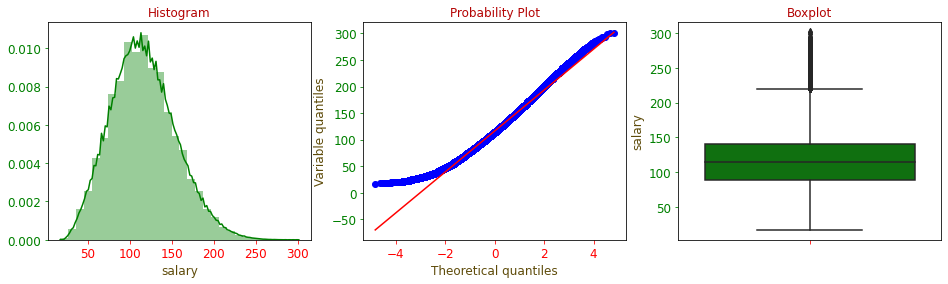

In [14]:
eda.diagnostic_plots(train,'salary')

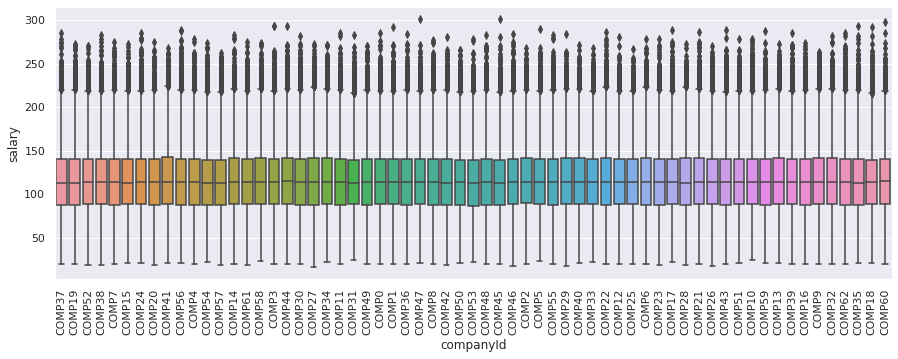

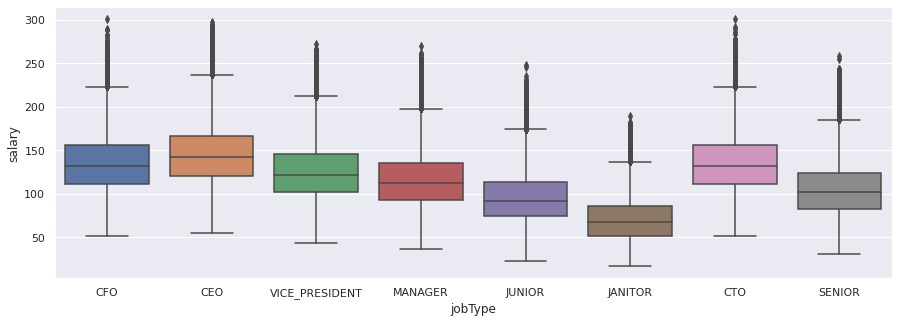

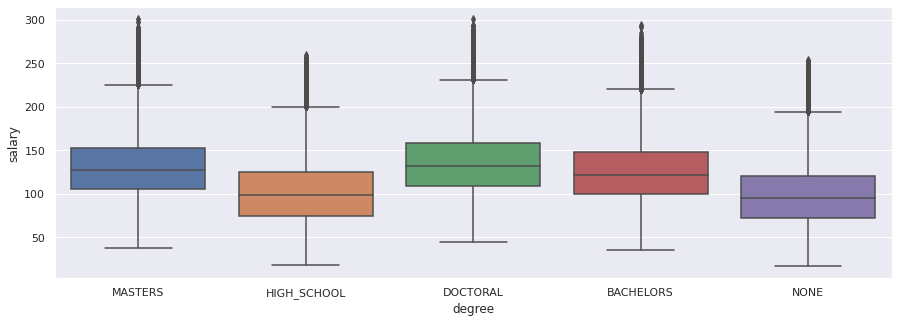

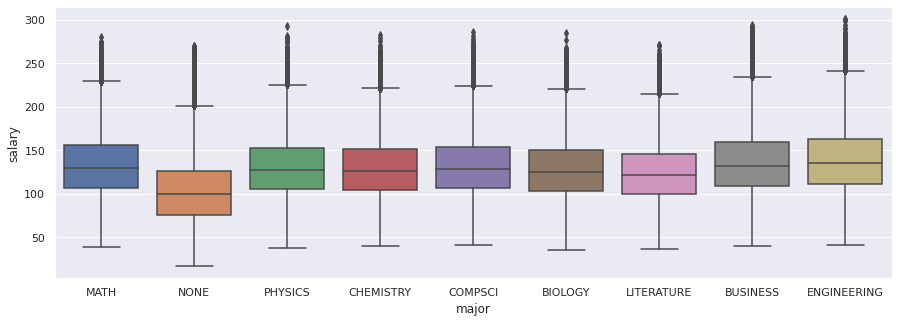

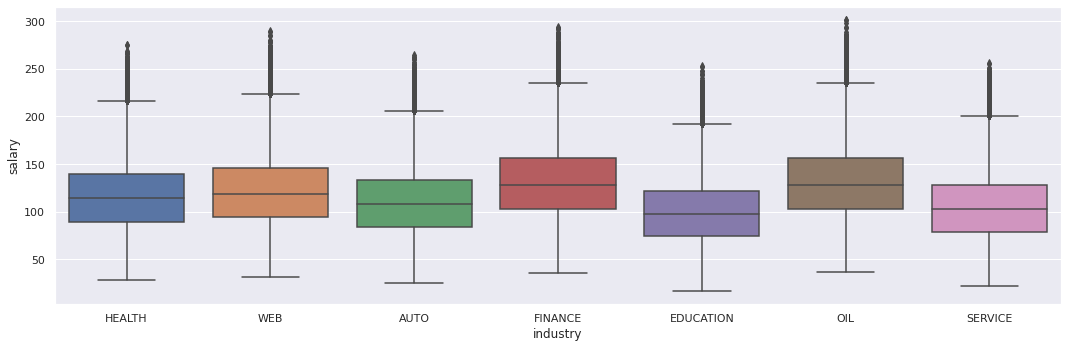

In [15]:
eda.boxplot(train,categorical,fig_h=15,fig_w=5)

In [16]:
col_list = ['jobType','degree','major','industry']
eda.find_stats(train, var_list = col_list)

--------------------------------------------------------------------------------------------------------------
                 Count  .05  .25  .50  .75  .95  Mean  Median  Min  Max
jobType                                                                
JANITOR         124869   36   52   68   86  116    70      68   17  189
JUNIOR          124573   53   74   92  114  149    95      92   23  248
SENIOR          125870   62   83  102  124  160   105     102   31  258
MANAGER         125110   71   93  112  135  171   115     112   37  270
VICE_PRESIDENT  125223   79  102  122  146  183   125     122   44  272
CFO             124359   87  111  132  156  195   135     132   51  301
CTO             125038   87  111  132  156  195   135     132   51  301
CEO             124767   95  120  142  167  207   145     142   55  298
--------------------------------------------------------------------------------------------------------------
              Count  .05  .25  .50  .75  .95  Mean  Median

In [17]:
lower_limit, upper_limit = eda.find_skewed_boundaries(train, 'salary', 1.5)

Lower boundary : 8.5 | Upper boundary : 220.5


In [18]:
lower_quantile, upper_quantile = eda.find_boundaries(train, 'salary', lw=0.05, up=0.95)

0.05 quantile : 56.0 | 0.95 quantile : 184.0


In [19]:
eda.find_stats(train, var_list = ['jobType'])

--------------------------------------------------------------------------------------------------------------
                 Count  .05  .25  .50  .75  .95  Mean  Median  Min  Max
jobType                                                                
JANITOR         124869   36   52   68   86  116    70      68   17  189
JUNIOR          124573   53   74   92  114  149    95      92   23  248
SENIOR          125870   62   83  102  124  160   105     102   31  258
MANAGER         125110   71   93  112  135  171   115     112   37  270
VICE_PRESIDENT  125223   79  102  122  146  183   125     122   44  272
CFO             124359   87  111  132  156  195   135     132   51  301
CTO             125038   87  111  132  156  195   135     132   51  301
CEO             124767   95  120  142  167  207   145     142   55  298
--------------------------------------------------------------------------------------------------------------


In [20]:
eda.find_outlier_records(train,var='jobType',var_filt='CEO',target_filt=207).head()

Total count :  124767
Above IQR :  6213
Outliers % :  4.979682127485633


,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
572777,COMP60,CEO,MASTERS,ENGINEERING,OIL,22,1,298
293221,COMP44,CEO,DOCTORAL,ENGINEERING,OIL,19,18,294
911747,COMP3,CEO,BACHELORS,BUSINESS,FINANCE,24,28,294
503962,COMP3,CEO,DOCTORAL,PHYSICS,OIL,24,1,293
905713,COMP35,CEO,DOCTORAL,BUSINESS,FINANCE,16,17,293


In [27]:
fe = transformfeature('salary')

In [28]:
fe.cat_ordered_mean_encoding(train,categorical).corr()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
companyId,1.000000,0.004787,0.003700,0.003860,0.002308,0.002029,-0.002451,0.008336
jobType,0.004787,1.000000,0.201688,0.167354,0.002113,0.001005,-0.000178,0.578840
degree,0.003700,0.201688,1.000000,0.638605,0.001262,0.000195,0.001806,0.383978
major,0.003860,0.167354,0.638605,1.000000,-0.000203,-0.000136,0.001151,0.346150
industry,0.002308,0.002113,0.001262,-0.000203,1.000000,0.000605,-0.001158,0.293881
yearsExperience,0.002029,0.001005,0.000195,-0.000136,0.000605,1.000000,0.000673,0.374991
milesFromMetropolis,-0.002451,-0.000178,0.001806,0.001151,-0.001158,0.000673,1.000000,-0.297679
salary,0.008336,0.578840,0.383978,0.346150,0.293881,0.374991,-0.297679,1.000000


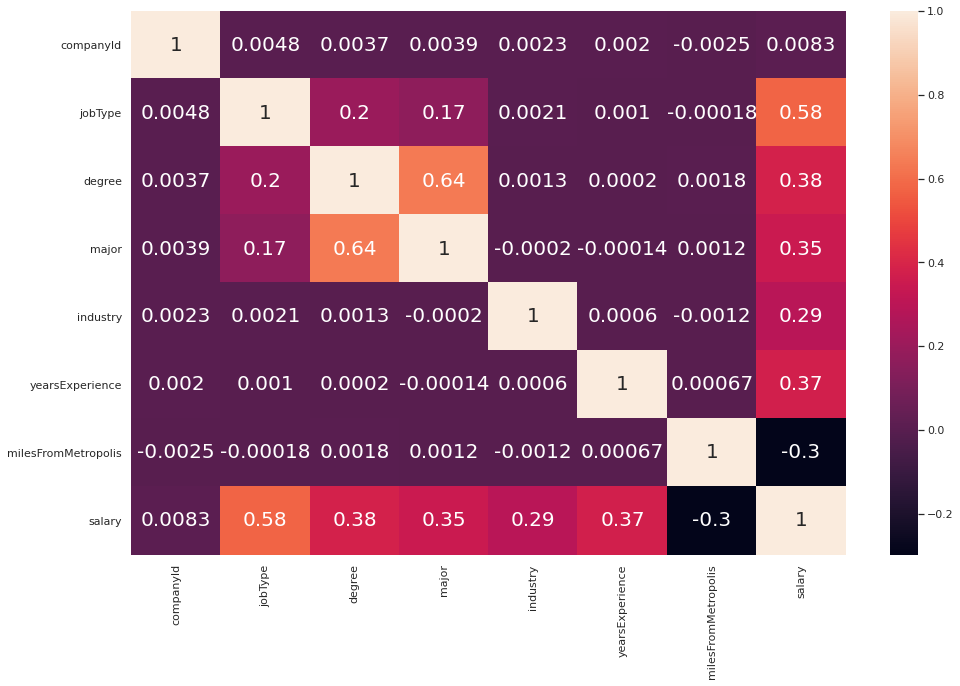

In [29]:
eda.heatmap(train,categorical,16,10)

### ---- 5 Establish a baseline ----

### ---- 6 Hypothesize solution ----

# Part 3 - DEVELOP

### ---- 7 Engineer features  ----

In [25]:
class transformfeature:
    
    def __init__(self,target,disc_var_list=None,bins=None):
        
        self.disc_var_list = disc_var_list
        self.bins = bins
        self.target = target
        
        
    def discretiser(self, X):
        
        X_transform = X.copy()
        
        disc = EqualWidthDiscretiser(bins=self.bins, variables = self.disc_var_list)
        disc.fit(X_transform)
        X_transform = disc.transform(X_transform)
        
        return X_transform
    
    def remove_strings(self, X, var):
        
        X_transform = X.copy()
        
        X_transform[var] = X_transform[var].str.replace('[^0-9]', '').astype(int)
        
        return X_transform
    
    def cat_ordered_mean_encoding(self, X,categorical):

        df = X.copy()

        for col in categorical:

            col_mean = df.groupby([col])[self.target].mean().sort_values(ascending=True).index
            col_dict = {val: key for key, val in enumerate(col_mean,1)}

            df[col] = df[col].map(col_dict).astype(int)

        return df
    
    def remove_outliers(self, X, lq=0.001, uq = 0.999):
        
        df_X = X.copy()
        df_q95 = pd.DataFrame(df_X.groupby(['jobType','industry','degree'])['salary'].quantile(uq))
        df_q05 = pd.DataFrame(df_X.groupby(['jobType','industry','degree'])['salary'].quantile(lq))
                

        for i in df_q95.index:
            df_X.loc[((df_X.jobType == i[0]) & \
                      (df_X.industry == i[1]) &\
                      (df_X.degree == i[2]) &\
                      (df_X.salary > df_q95.loc[i,'salary']) \
                     ) ,'salary'] = df_q95.loc[i,'salary']
            
        for i in df_q05.index:
            df_X.loc[((df_X.jobType == i[0]) & \
                      (df_X.industry == i[1]) &\
                      (df_X.degree == i[2]) &\
                      (df_X.salary < df_q05.loc[i,'salary']) \
                     ) ,'salary'] = df_q05.loc[i,'salary']
            
        return df_X

In [30]:
train_ready = train.copy()
train_ready = fe.remove_outliers(train_ready,lq=0.05, uq = 0.95)

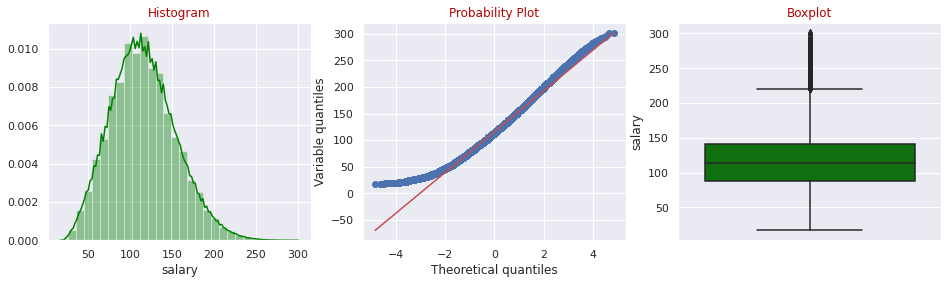

In [31]:
eda.diagnostic_plots(train,'salary')

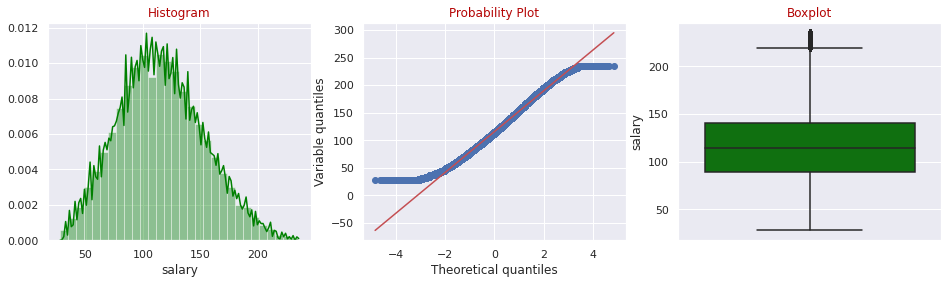

In [32]:
eda.diagnostic_plots(train_ready,'salary')

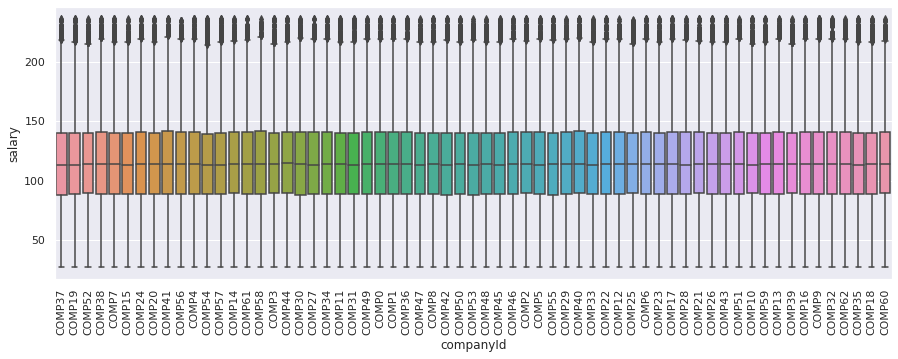

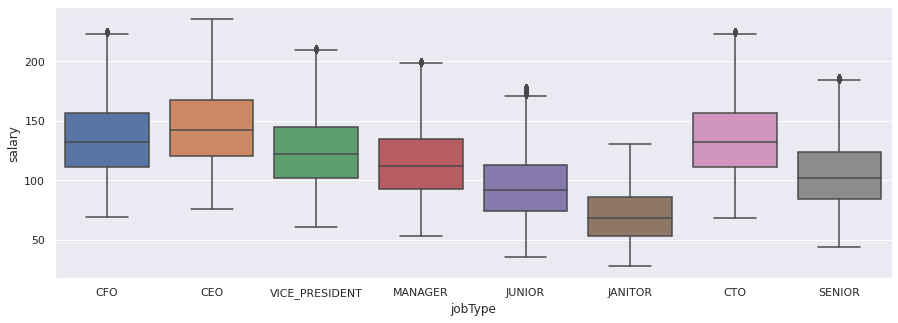

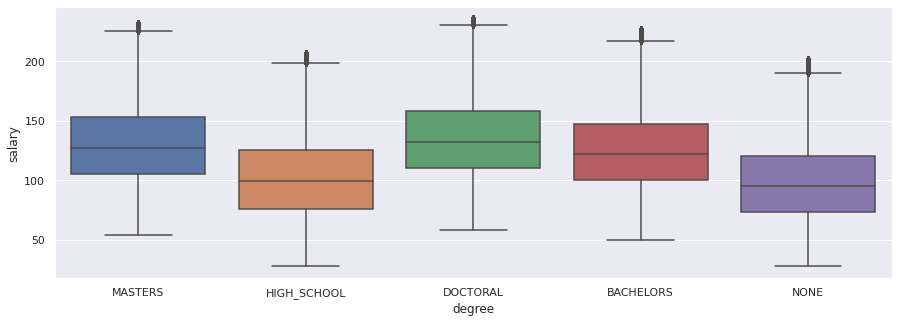

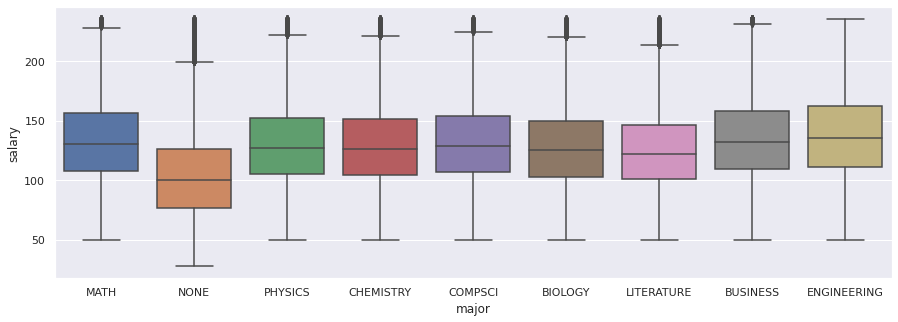

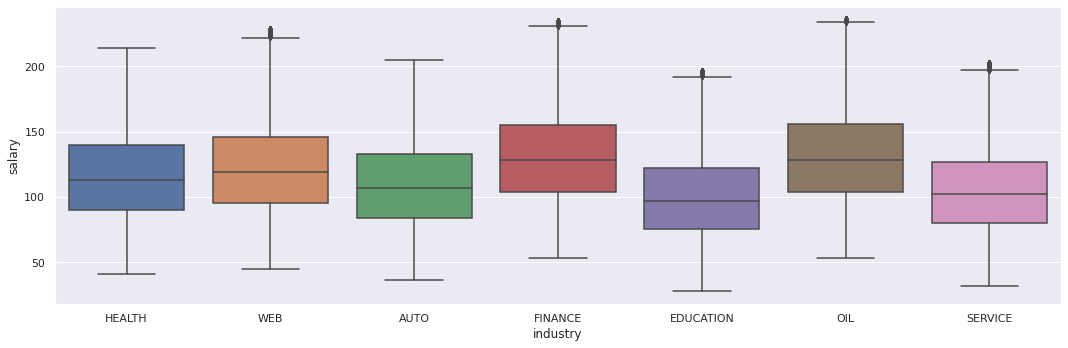

In [33]:
eda.boxplot(train_ready,categorical,fig_h=15,fig_w=5)

In [34]:
col_list = ['jobType','degree','major','industry','yearsExperience']
eda.find_stats(train_ready, var_list = ['jobType'])

--------------------------------------------------------------------------------------------------------------
                 Count  .05  .25  .50  .75  .95  Mean  Median  Min  Max
jobType                                                                
JANITOR         124869   36   53   68   86  112    70      68   28  130
JUNIOR          124573   54   74   92  113  145    94      92   36  177
SENIOR          125870   63   84  102  124  156   105     102   44  186
MANAGER         125110   72   93  112  135  167   114     112   53  199
VICE_PRESIDENT  125223   81  102  122  145  179   124     122   61  210
CFO             124359   89  111  132  156  191   135     132   69  224
CTO             125038   89  111  132  156  190   135     132   68  224
CEO             124767   97  120  142  167  202   144     142   76  235
--------------------------------------------------------------------------------------------------------------


In [35]:
eda.find_outlier_records(train_ready,var='jobType',var_filt='JANITOR',target_filt=116).head()

Total count :  124869
Above IQR :  4834
Outliers % :  3.871257077417133


,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
999273,COMP14,JANITOR,NONE,NONE,OIL,20,2,130.0
682213,COMP18,JANITOR,HIGH_SCHOOL,NONE,OIL,21,8,130.0
449486,COMP11,JANITOR,HIGH_SCHOOL,NONE,OIL,17,8,130.0
450350,COMP11,JANITOR,HIGH_SCHOOL,NONE,OIL,18,1,130.0
450703,COMP4,JANITOR,NONE,NONE,OIL,24,22,130.0


In [36]:
train_ready = fe.cat_ordered_mean_encoding(train_ready,categorical)

In [37]:
X_train, y_train = data.split_X_y(train_ready, 'salary')

In [38]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.25,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((749856, 7), (249953, 7), (749856,), (249953,))

### ---- 8 Create models ----

In [22]:
def model_eval(X,y):
    # prepare configuration for cross validation test harness
    seed = 7
    # prepare models
    models = []
    models.append(('LR', LinearRegression()))
    models.append(('RFR', RandomForestRegressor(n_estimators = 10, random_state = 0)))
    models.append(('DTR', DecisionTreeRegressor(random_state = 0)))
    models.append(('GBR', GradientBoostingRegressor(n_estimators=500, max_depth=5, loss='ls')))
    models.append(('XGB', XGBRegressor(n_estimators=1000,max_depth=4,learning_rate=0.1, booster='gbtree')))
    # evaluate each model in turn
    results = []
    names = []
    scoring = 'neg_mean_squared_error'
    for name, model in models:
        kfold = KFold(n_splits=5)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring,n_jobs=-1)
        results.append(cv_results)
        names.append(name)        
        msg = "%s: %f (%f)" % (name, -1.0*np.mean(cv_results), cv_results.std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()
    return names,results

### ---- 9 Test models ----

LR: 345.401812 (1.164547)
RFR: 378.093837 (1.324045)
DTR: 649.799617 (3.182182)
GBR: 311.104993 (1.213087)
XGB: 310.068875 (1.213799)


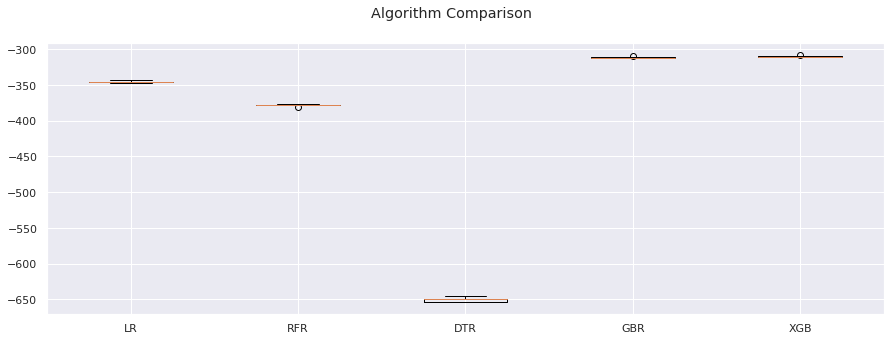

(['LR', 'RFR', 'DTR', 'GBR', 'XGB'],
 [array([-346.58190611, -343.35545305, -346.4796119 , -345.20491373, -345.38717311]),
  array([-378.54205617, -376.31721641, -380.32838572, -377.5936626 , -377.68786654]),
  array([-652.85683442, -644.66770989, -653.47798854, -648.7408218 , -649.25473098]),
  array([-311.77798085, -308.84971745, -312.35190926, -311.59492149, -310.95043553]),
  array([-310.77578221, -307.83260797, -311.20110391, -310.7699983 , -309.76488425])])

In [46]:
model_eval(X_train,y_train)

### ---- 10 Select best model  ----

In [ ]:
#create an object for xgboost regressor
xgb = GradientBoostingRegressor()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = ['4','5','6']
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
param_grid = {
               'n_estimators': n_estimators,               
               'max_depth': max_depth,
               'learning_rate': [0.1],
               'booster' :['gbtree'],
               'objective' :['reg:squarederror']
             }


grid = RandomizedSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train,y_train)
y_pred = grid.predict(X_train)

print(grid.best_score_)
print(grid.best_params_)
print("Mean squared error :",metrics.mean_squared_error(y_train, y_pred, squared=False)) 
print("r2_score :",metrics.r2_score(y_train, y_pred))

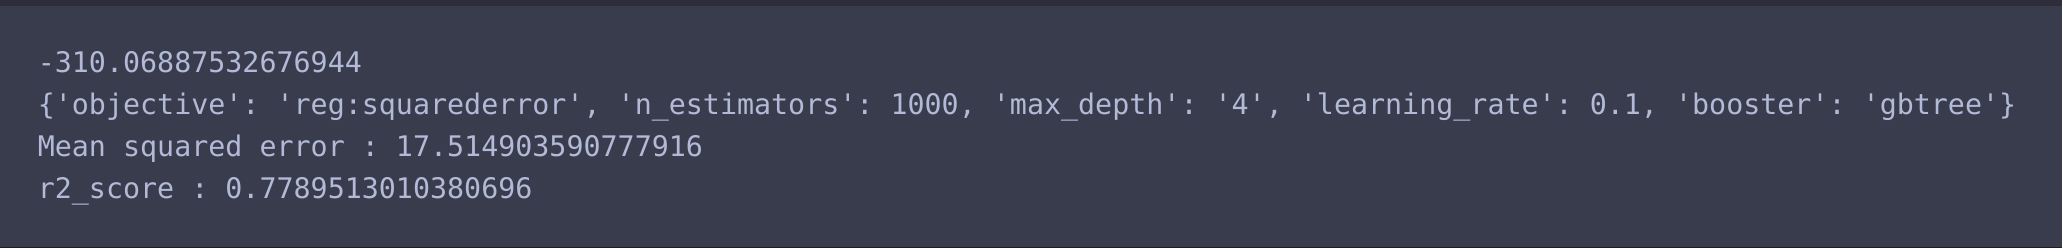

In [43]:
y_pred = grid.predict(X_test)
print("Mean squared error :",metrics.mean_squared_error(y_test, y_pred, squared=False)) 
print("r2_score :",metrics.r2_score(y_test, y_pred))

Mean squared error : 17.63100583783094
r2_score : 0.7774296044798756


# Part 4 - DEPLOY

# ---- 11 Automate pipeline ----

### ---- 12 Deploy solution ----

In [ ]:
train.shape